In [23]:
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc
import json
from matplotlib_venn import venn2_unweighted, venn3_unweighted
from matplotlib import pyplot as plt

In [2]:
#!cd
!python ../src/masskit/apps/process/libraries/pubchem_links.py

Attempting to find or download data files:
Using cache file C:\Users\slottad\.masskit_cache\pubchem\pubchem-wiki.json
Using cache file C:\Users\slottad\.masskit_cache\pubchem\CID-InChI-Key.gz
Using cache file C:\Users\slottad\.masskit_cache\pubchem\CID-Patent.gz
Using cache file C:\Users\slottad\.masskit_cache\pubchem\CID-PMID.gz


In [3]:
# Load NIST Library data files
nist_files = [
    '~/data/nist/ei/2023/main_2023.parquet',
    '~/data/nist/ei/2023/rep_2023.parquet',
    '~/data/nist/ei/2023/ri_2023.parquet',
    '~/data/nist/tandem/2023/apci_msms_2023.parquet',
    '~/data/nist/tandem/2023/hr_msms_2023.parquet',
    '~/data/nist/tandem/2023/lr_msms_2023.parquet'
]
tables = []
for file in nist_files:
    table = pq.read_table(file, columns=['id', 'name', 'inchi_key', 'inchi_key_orig'])
    tables.append(table)
tables

[pyarrow.Table
 id: uint64
 name: string
 inchi_key: string
 inchi_key_orig: string
 ----
 id: [[1,2,3,4,5,...,4997,4998,4999,5000,5001],[5002,5003,5004,5005,5006,...,9997,9998,9999,10000,10001],...,[340009,340010,340011,340012,340013,...,345004,345005,345006,345007,345008],[345009,345010,345011,345012,345013,...,347101,347102,347103,347104,347105]]
 name: [["Hydrogen","Deuterium","Diazirine","Methane, diazo-","Ketene",...,"Pentafluoropropionamide, N-allyl-N-(3-methylbutyl)-","5-Bromo-2-cyclopentylamino-3-nitropyridine","4H-1-Benzopyran-4-one, 5-hydroxy-2-methyl-7-(2-propenyloxy)-","3,4'-Dimethyl-2,3'-dioxobicyclohexyl-5-ene-3,4'-dicarboxylic acid, dimethyl ester","Eudesma-4(14),7(11)-dien-8-one"],["2-Diallylamino-N-phenyl-2-thioxo-acetamide","Allyl-(4,6-di-piperidin-1-yl-[1,3,5]triazin-2-yl)-amine","Cyclopropanecarboxamide, N-[7-(cyclopropylcarbonyl)-2,3-dihydro-1,4-benzodioxin-6-yl]-","Acetamide, 2-(cyclohexylamino)-N-(5,6,7,8-tetrahydro-2-methyl-4-oxo[1]benzothieno[2,3-d]pyrimidin-3

In [4]:
# Get the set of INCHI Keys from the NIST Libraries
inchi_keys = pa.concat_arrays( [ i.column("inchi_key").combine_chunks() for i in tables ] )
inchi_keys_orig = pa.concat_arrays( [ i.column("inchi_key_orig").combine_chunks() for i in tables ] )

# Use a filter to find which keys don't match
#inchi_ne = (pc.not_equal(pc.field("inchi_key"), pc.field("inchi_key_orig")))
#inchi_ne = (pc.field("inchi_key") != pc.field("inchi_key_orig"))
#inchi_ne
#tables[0].filter(inchi_ne).shape

# Find the full set of keys
ik_set = set(inchi_keys.unique().to_pylist())
ik_orig_set = set(inchi_keys_orig.unique().to_pylist())
ik_full_set = ik_set | ik_orig_set

In [5]:
# Find the overlapping set with PubChem
cid2inchi_full = pq.read_table('~/.masskit_cache/pubchem/cid-inchi.parquet', columns=['cid', 'inchi_key'])
table2 = pa.table({'inchi_key': ik_full_set})
cid2inchi = cid2inchi_full.join(table2,keys='inchi_key',join_type='inner')
pubchem_inchi = set(cid2inchi['inchi_key'].to_pylist())

In [6]:
cid2inchi_full.num_rows

114772796

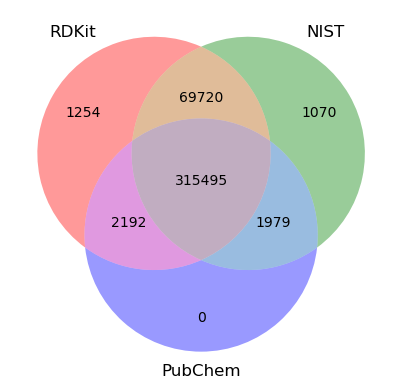

In [7]:
# Show overlaps
venn3_unweighted([ik_set,ik_orig_set, pubchem_inchi],set_labels=("RDKit","NIST", "PubChem"))

In [8]:
cid2inchi

pyarrow.Table
cid: int64
inchi_key: string
----
cid: [[478049,478572,478577,478592,478811,...,91732524,91732525,91732526,91732527,91732528],[555320,555327,555329,555330,555332,...,165365255,165365256,165365257,165366762,166530468],...,[518275,518310,518325,518457,518459,...,168006556,168007633,163750808,163753121,163770541],[1851236,1851527,1852292,1853048,1854043,...,162986289,162986517,164845047,166444301,167563521]]
inchi_key: [["KDPBLDOVCGAWNQ-UHFFFAOYSA-N","INPHXCCBDRGBRF-UHFFFAOYSA-N","DSZRZFCUYHAAAE-UHFFFAOYSA-N","QZEAJJHJTPPDMU-UHFFFAOYSA-N","UGZDFLLCOFLFNY-UHFFFAOYSA-N",...,"DVUCLMCSYZFBOY-UHFFFAOYSA-N","FFVOYKANDKNBHJ-UHFFFAOYSA-N","ZMRFLEFXODCPEW-UHFFFAOYSA-N","OQNRAAXJLURWQU-UHFFFAOYSA-N","WGOPIBTWJGHGDP-UHFFFAOYSA-N"],["GTNJQQRPSTYDAO-UHFFFAOYSA-N","VNUFFRQZHQDEQT-UHFFFAOYSA-N","BFFJWVFAADWBQQ-UHFFFAOYSA-N","UBHCNGACASUDAJ-UHFFFAOYSA-N","ZRCGVVHTCXSHOK-UHFFFAOYSA-N",...,"WROCSMZNSLKYDI-INIZCTEOSA-N","SHELRBQJCJWWQC-ZDUSSCGKSA-N","GIUNLIQZFMBOGJ-LJQANCHMSA-N","HWYCRLFVQVFKP

In [9]:
# Find the pubmed mentions counts
cid2pmid_full = pq.read_table('~/.masskit_cache/pubchem/cid-pmid.parquet', columns=['cid', 'pmid'])
cid2pmid = cid2inchi.join(cid2pmid_full, keys='cid', join_type='inner')
pmid_counts = cid2pmid.group_by(['cid', "inchi_key"]).aggregate([("pmid", "count"),("pmid", "count_distinct")]).sort_by([("pmid_count_distinct","descending")])
pmid_counts

pyarrow.Table
cid: int64
inchi_key: string
pmid_count: int64
pmid_count_distinct: int64
----
cid: [[702,5997,962,977,24749,...,102590315,121491808,121499159,122412734,136274666]]
inchi_key: [["LFQSCWFLJHTTHZ-UHFFFAOYSA-N","HVYWMOMLDIMFJA-DPAQBDIFSA-N","XLYOFNOQVPJJNP-UHFFFAOYSA-N","MYMOFIZGZYHOMD-UHFFFAOYSA-N","GZCGUPFRVQAUEE-UHFFFAOYSA-N",...,"WEBOANBERJZFSE-UHFFFAOYSA-N","DGQMLBSSRFFINY-LJQANCHMSA-N","PEKZLFZZBGBOPJ-UHFFFAOYSA-N","QDWKGEFGLQMDAM-JJIBRWJFSA-N","OSQQVGKLYYRVIV-UHFFFAOYSA-N"]]
pmid_count: [[258046,221327,190235,179111,178556,...,1,1,2,1,1]]
pmid_count_distinct: [[233597,193424,190208,178975,178554,...,1,1,1,1,1]]

In [10]:
# Find the patent count mentions
cid2patent_full = pq.read_table('~/.masskit_cache/pubchem/cid-patent.parquet')

# The Patent table is too big, so we need to join by parts
sz = 50000000
tables = []
for i in range(0, cid2patent_full.num_rows, sz):
    subtbl = cid2patent_full.slice(offset=i,length=sz)
    jointbl = cid2inchi.join(subtbl, keys='cid', join_type='inner')
    tables.append(jointbl)
    print(f"Working on row numbers {i:,d} through {i+sz-1:,d}")
cid2patent = pa.concat_tables(tables)
patent_counts = cid2patent.group_by(['cid', "inchi_key"]).aggregate([("patent_id", "count")]).sort_by([("patent_id_count","descending")])
patent_counts

Working on row numbers 0 through 49,999,999
Working on row numbers 50,000,000 through 99,999,999
Working on row numbers 100,000,000 through 149,999,999
Working on row numbers 150,000,000 through 199,999,999
Working on row numbers 200,000,000 through 249,999,999
Working on row numbers 250,000,000 through 299,999,999
Working on row numbers 300,000,000 through 349,999,999
Working on row numbers 350,000,000 through 399,999,999
Working on row numbers 400,000,000 through 449,999,999
Working on row numbers 450,000,000 through 499,999,999
Working on row numbers 500,000,000 through 549,999,999
Working on row numbers 550,000,000 through 599,999,999
Working on row numbers 600,000,000 through 649,999,999
Working on row numbers 650,000,000 through 699,999,999
Working on row numbers 700,000,000 through 749,999,999
Working on row numbers 750,000,000 through 799,999,999


pyarrow.Table
cid: int64
inchi_key: string
patent_id_count: int64
----
cid: [[107428,453,6251,243,232,...,160502410,163912994,159184515,163378837,163890326]]
inchi_key: [["BJHIKXHVCXFQLS-PYWDMBMJSA-N","FBPFZTCFMRRESA-UHFFFAOYSA-N","FBPFZTCFMRRESA-KVTDHHQDSA-N","WPYMKLBDIGXBTP-UHFFFAOYSA-N","ODKSFYDXXFIFQN-UHFFFAOYSA-N",...,"QRYLYPPISKTAJM-UHFFFAOYSA-N","QTUOLUOIJNLFEE-UHFFFAOYSA-N","KNHUNLXVPJHCNZ-UHFFFAOYSA-N","WHRRUOMMNPYKAW-UHFFFAOYSA-N","QAZIHQDLTJDPFV-UHFFFAOYSA-N"]]
patent_id_count: [[680997,638068,592031,525252,509079,...,1,1,1,1,1]]

In [13]:
counts_schema = pa.schema([
            pa.field("cid", pa.int64()),
            pa.field("pageviews", pa.int64()),
            pa.field("months", pa.int64()),
            pa.field("refs", pa.int64()),
            pa.field("average_pageviews", pa.float32())
        ])
counts_schema.empty_table().to_pydict()

{'cid': [], 'pageviews': [], 'months': [], 'refs': [], 'average_pageviews': []}

In [19]:
cid2wikipedia = pq.read_table('~/.masskit_cache/pubchem/cid-wikipedia.parquet')
print(f"Num rows: {cid2wikipedia.num_rows}")
cid2wikipedia

Num rows: 27104


pyarrow.Table
cid: int64
pageviews: int64
months: int64
references: int64
average_pageviews: float
----
cid: [[23987,23912,23963,23957,31192,...,2762553,32369,136194,10199167,3084179]]
pageviews: [[7870404,796698,7116837,2050435,890333,...,88,116,121,351,163]]
months: [[188,94,94,94,94,...,2,3,2,3,2]]
references: [[2,1,1,1,1,...,1,1,1,1,1]]
average_pageviews: [[41863.85,8475.511,75711.03,21813.139,9471.628,...,44,38.666668,60.5,117,81.5]]

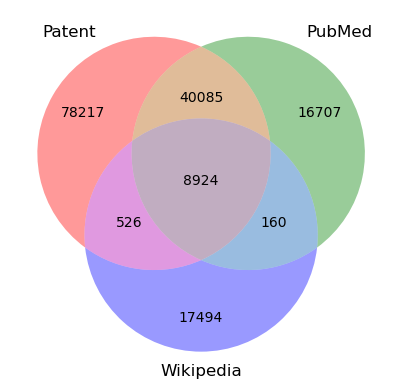

In [20]:
patent_set = set(cid2patent['cid'].to_pylist())
pmid_set = set(cid2pmid['cid'].to_pylist())
wiki_set = set(cid2wikipedia['cid'].to_pylist())

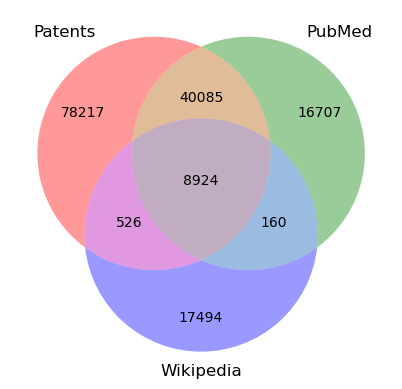

In [27]:
df = venn3_unweighted([patent_set,pmid_set, wiki_set],set_labels=("Patents","PubMed", "Wikipedia"))
plt.savefig("publications_venn.pdf",format="pdf", bbox_inches="tight")

In [34]:
numchem = len(patent_set | pmid_set | wiki_set)
print("Total chemicals in publications:", numchem)
print("Unique INCHIKeys:", len(ik_set), len(ik_orig_set), len(ik_full_set))
numchem/len(ik_full_set)*100

Total chemicals in publications: 162113
Unique INCHIKeys: 388661 388264 391710


41.385974317735055

Unique INCHIKeys: 388661 388264 391710
